In [283]:
from sklearn.ensemble import RandomTreesEmbedding
import numpy as np

from sklearn.base import BaseEstimator
from scipy.optimize import brenth
from functools import reduce

In [285]:
from functools import reduce
from functools import partial

In [286]:
def merge_pairs(cdf1,cdf2,weight1,weight2,alpha,option = 'linear'):
    '''
    returns cdf of merged pairs
    '''
    if cdf1[1][0] < cdf2[1][0]:
        if cdf1[1][1] < cdf2[1][1]:
            return ([cdf1[0][0],cdf1[0][1] ],[cdf1[1][0],cdf1[1][1]])
        else:
            return ([cdf1[0][0],cdf2[0][1] ],[cdf1[1][0],cdf2[1][1]])
    else:
        if cdf1[1][1] < cdf2[1][1]:
            return ([cdf2[0][0],cdf1[0][1] ],[cdf2[1][0],cdf1[1][1]])
        else:
            return ([cdf2[0][0],cdf2[0][1] ],[cdf2[1][0],cdf2[1][1]])
def select_pair(data,alpha):
    N = float(len(data)-1)
    if N > 0.0:
        ind = int(np.floor(alpha*N))
        return ([data[ind],data[ind+1]],[float(ind)/N,float(ind+1)/N])
    else:
        return (data,[1.0])


from sklearn.base import BaseEstimator
from functools import reduce
class quantregTree(BaseEstimator):
    def __init__(self,alpha,n_trees,max_depth=3):
        self.alpha = alpha
        self.n_trees = n_trees
        self.weight_leafs = None
        self.rte = None
        self.leafs = dict()
        self.max_depth = max_depth
        
    def fit(self,X,y):
        self.rte = RandomTreesEmbedding(n_estimators=self.n_trees, max_depth=self.max_depth,min_samples_leaf=3) 
        X_ = self.rte.fit_transform(X,y)
        self.weight_leafs = X_.sum(axis=0)
        indices = X_.nonzero()
        leafs = indices[1]
        rows = indices[0]
        for leaf in np.unique(leafs):
            ####### bin leafs #######
            values = np.sort(y[rows[leafs==leaf]])
            cdf = select_pair(values,self.alpha)
            self.leafs.update({leaf:cdf})  

        return self
    def predict(self,X):
        indices = self.rte.transform(X).nonzero()
        leafs = indices[1]
        rows = indices[0]
        def quantile(n_row):
            leaf_list = leafs[n_row*self.n_trees:(n_row+1)*self.n_trees:]
            final_cdf = reduce(lambda x,n:merge_pairs(x,self.leafs[leaf_list[n]],n/(n+1),1/(n+1),self.alpha)\
                                   , np.arange(1,len(leaf_list)),self.leafs[leaf_list[0]] )
            return final_cdf[0][0]
        ypred = list(map(lambda n:quantile(n),range(X.shape[0])) )
        return ypred

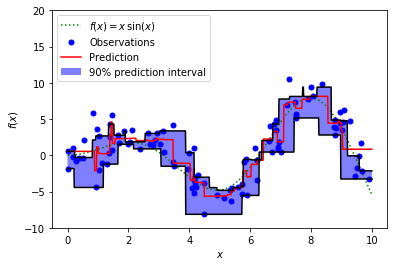

In [282]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

alpha = 0.95

qt_upper = quantregTree(alpha = alpha,n_trees=25)

qt_upper.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = qt_upper.predict(xx)

qt_lower = quantregTree(alpha = 1.0-alpha,n_trees=25,max_depth = 5)
qt_lower.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = qt_lower.predict(xx)

clf = GradientBoostingRegressor(loss='ls', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()